# Small baseline InSAR time-series bias analysis with closure_phase_bias.py (within the MintPy framework)

This tutorial accompanies [Zheng et al., TGRS, 2022](https://ieeexplore.ieee.org/document/9758802), in which a simple model explaining both the nonzero closure phase and systematic "bias" observed in small baseline InSAR time-series is provided. We developed an open-source code [closure_phase_bias.py](https://github.com/insarlab/MintPy/blob/main/mintpy/closure_phase_bias.py)<br>
<br>
In the following, we use the datasets of Barstow-Bristol Trough, CA (same datasets as shown in [Zheng et al., TGRS, 2022](https://ieeexplore.ieee.org/document/9758802)) to illstrate the use of [closure_phase_bias.py](https://github.com/insarlab/MintPy/blob/main/mintpy/closure_phase_bias.py). The dataset can be downloaded from https://doi.org/10.5281/zenodo.6558341
<br><br>
While the functions are written with the data format in MintPy in mind, they should still be of value if one is interested in adapting this code for other data formats.

Reference:<br>
Y. Zheng, H. Fattahi, P. Agram, M. Simons and P. Rosen, "On Closure Phase and Systematic Bias in Multi-looked SAR Interferometry," in IEEE Transactions on Geoscience and Remote Sensing, 60, doi: [10.1109/TGRS.2022.3167648](https://ieeexplore.ieee.org/document/9758802).

## Presemble

We processed 153 Sentinel 1 A/B SAR images (descending path 173) using ISCE2 (https://github.com/isceframework/isce2) from February 2017 to January 2021 of the Barstow-Bristol Trough area, CA, USA. <br>
<p align="left">
  <img width="500" src="../docs/Drylake_googlemap.png">
</p>     
<p style="text-align: center;">
    (Figure from Zheng et al., TGRS, 2022)
</p>

The average velocity maps of bw-1, bw-5, and bw-10 are shown in the figure below (top). Note that there are systematic descrepancies in these velocity maps. These descrepancies result from temporally inconsistent processes. We can use closure_phase_bias.py (https://github.com/insarlab/MintPy/blob/main/mintpy/closure_phase_bias.py) to estimate and remove these descrepancies.
<p align='left'>
    <img src="../docs/drylake_velocitymaps.png" width="500" />
</p>

<p style="text-align: center;">
    (Figure from Zheng et al., TGRS, 2022)
</p>

## closure_phase_bias.py -- Introduction

In this script, we offer three options:<br>
1.  create_mask -- identify areas that are prone to temorally inconsistent processes, and create a map (mask)<br>
2.  quick_bias_estimate -- provides a quick and approximate estimate of the "bias" time-series<br>
3.  bias_estimate -- provides an estimate of the "bias" time-series as per introduced in Zheng et al., TGRS, 2022<br>

In [1]:
!closure_phase_bias.py --help

usage: closure_phase_bias.py [-h] [-i IFGRAM_STACK] [--nl NL] [--bw BW]
                             [--num_sigma NUM_SIGMA] [--epi EPISILON]
                             [--noupdate] [-o OUTDIR]
                             [-a {quick_bias_estimate,create_mask,bias_estimate}]
                             [-c {lsf,pbs,slurm,local}]
                             [--num-worker NUMWORKER] [--config CONFIG]
                             [--ram MAXMEMORY]

Mask / estimate / correct for phase non-closure related biases.

optional arguments:
  -h, --help            show this help message and exit
  -i IFGRAM_STACK, --ifgramstack IFGRAM_STACK
                        interferogram stack file that contains the unwrapped phases
  --nl NL               connection level that we are correcting to (or consider as no bias)
  --bw BW               bandwidth of time-series analysis that you want to correct
  --num_sigma NUM_SIGMA
                        Threashold for phase (number of sigmas,0-infty), def

## closure_phase_bias.py -- create_mask (option 1)
<br>
This is the most straightforward option amongst the three.<br>
The only input requirement is the ifgramStack.h5 that contains the interferogram stack.

In [2]:
!closure_phase_bias.py -i inputs/ifgramStack.h5 --nl 20 --num_sigma 2 -o . -a create_mask --ram 8

open ifgramStack file: ifgramStack.h5
scene length, width 1270 1125
reference pixel in y/x: (751, 884) from dataset: unwrapPhase
number of SLC found :  153
first SLC:  20170203
last  SLC:  20210101
maximum memory size: 8.0E+00 GB
split 1270 lines into 4 patches for processing
    with each patch up to 320 lines
(0, 0, 1125, 320)

------- processing patch 1 out of 4 --------------
box width:  1125
box length: 320
Number of closure measurements expected,  133
Number of closure measurements found,  133
(0, 320, 1125, 640)

------- processing patch 2 out of 4 --------------
box width:  1125
box length: 320
Number of closure measurements expected,  133
Number of closure measurements found,  133
(0, 640, 1125, 960)

------- processing patch 3 out of 4 --------------
box width:  1125
box length: 320
Number of closure measurements expected,  133
Number of closure measurements found,  133
(0, 960, 1125, 1270)

------- processing patch 4 out of 4 --------------
box width:  1125
box length: 310
N

After the above step, two files are created: avgCpxClosurePhase.h5 and maskClosurePhase.h5.<br>
avgwcp.h5 contains the amplitude and phase of the complex number $\tau = 1/K \sum_{k=1}^K e^{j\Phi_k^{n_l}}$
(Fig.5 in Zheng et al., TGRS, 2022)

view.py ./avgCpxClosurePhase.h5 amplitude -v 0 1 -c gray --alpha 0.75 --noaxis --noverbose


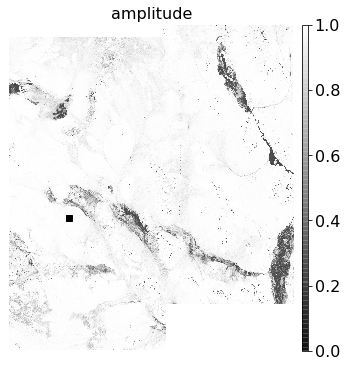

view.py ./avgCpxClosurePhase.h5 phase -v -1 1 -c vik --alpha 0.75 --noaxis --noverbose


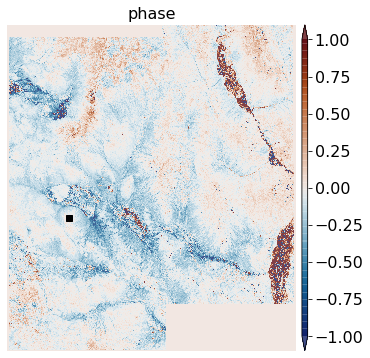

In [3]:
from mintpy import view
view.main('./avgCpxClosurePhase.h5 amplitude -v 0 1 -c gray --alpha 0.75 --noaxis --noverbose'.split())
view.main('./avgCpxClosurePhase.h5 phase -v -1 1 -c vik --alpha 0.75 --noaxis --noverbose'.split())

maskClosurePhase.h5 is created by tresholding $|\tau|> 0.3$ (--epi 0.3) and $|\angle\tau| > 2\sigma$) (--numsigma 2)
(Fig.5 in Zheng et al., TGRS, 2022)

view.py ./maskClosurePhase.h5 -c gray --alpha 0.75 --noaxis --nocbar --noverbose


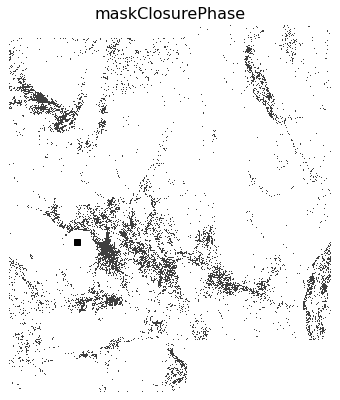

In [4]:
view.main('./maskClosurePhase.h5 -c gray --alpha 0.75 --noaxis --nocbar --noverbose'.split())

## closure_phase_bias.py -- quick_bias_estimate (option 2)

<br>
This is slightly more complicated than option 1 for two reasons: <br><br>
* 1  this option generates a new folder called "ClosurePhase" in which we will output closure phases with different connection levels.
<br><br>
* 2  this option requires that ifgramStack.h5 should be complete in terms of interferograms of connection level below your analysis bandwidth. For example, in our case, we have 153 SAR aquisitions, and we would like to correct a bw-1 analysis, and we set $n_l=20$. In order for this option to work properly, we need to have 152 con-1 and 133 con-20 interferograms stored in ifgramStack.h5. Missing interferograms can cause problems for this code.
<br><br>

This is a simplified solution comparing to option 3: <br><br>

Comparing to Option 3, this option is simlified in terms of the structure of the weight matrix W (eq.16 in Zheng et al., TGRS, 2022). In other words, we are ignoring the differences in the diagnoal components of W, and simplifying W to be $W = w(\Delta t) I$, $I$ is an identity matrix, $\Delta t$ is the average temoral span of interferograms for a given time-series anlaysis.
<br><br>
In the following we estimate and correct bw-5 time-series with both option 2 and option 3. bw-1 and bw-10 time-series corrections follow the exact same steps and are left as an exercise for the readers.

In [5]:
# I have already computed the closure phases I need so here I choose to not run function [cum_seq_unwclosurePhase]
# If you have computed some but not all needed closure phases, run without --noupdate_CP, existing files will not be computed again. 
!closure_phase_bias.py -i inputs/ifgramStack.h5 --bw 5 --nl 20 -a quick_bias_estimate --ram 8 -o . --noupdate

open ifgramStack file: ifgramStack.h5
--------------------------------------------------
create HDF5 file: ./Wratio.h5 with w mode
create dataset  : wratio        of <class 'numpy.float32'>   in size of (5, 1270, 1125)      with compression = None
create dataset  : bias_velocity of <class 'numpy.float32'>   in size of (5, 1270, 1125)      with compression = None
create dataset  : date          of |S8                       in size of (153,)               with compression = None
close  HDF5 file: ./Wratio.h5
maximum memory size: 8.0E+00 GB
split 1270 lines into 4 patches for processing
    with each patch up to 320 lines
(0, 0, 1125, 320)

------- processing patch 1 out of 4 --------------
box width:  1125
box length: 320
--------------------------------------------------
open  HDF5 file ./Wratio.h5 in a mode
writing dataset /wratio                    block: [0, 5, 0, 320, 0, 1125]
close HDF5 file ./Wratio.h5.
--------------------------------------------------
open  HDF5 file ./Wratio.h5

After this step, we should have a folder "closurePhase", a new HDF5 file "Wratio.h5" and a new HDF5 file "bias_timeseries_approx.h5".<br>
- ClosurePhase:
    contains subfolders that stores wrapped and unwrapped closure phases at different connection level.
- Wratio.h5:
    contains two datasets: Wratio-n and bias_velocity_n <br>
    Wratio-n : this is the $n^{th}$ diagonal component of $W^r$ (Eq.20 in Zheng et al., TGRS, 2022) -- $w(n\delta_t)/w(\delta_t)$ <br>
    bias_velocity-n: bias velocity in connection-n interferograms
- bias_timeseries_approx.h5
    a timeseries file for the estimated bias time-series
    
<br>
To get the bias velocity map, or correct bias time-series from the original time-series, just use "timeseries2velocity.py" and "diff.py" in MintPy 

In [6]:
!ls -l closurePhase/

total 0
drwxr-xr-x@ 1334 yjzheng  staff  42688 May 28 13:58 conn20_cp
drwxr-xr-x@ 1514 yjzheng  staff  48448 May 28 22:32 conn2_cp
drwxr-xr-x@ 1504 yjzheng  staff  48128 May 28 13:58 conn3_cp
drwxr-xr-x@ 1494 yjzheng  staff  47808 May 28 13:58 conn4_cp
drwxr-xr-x@ 1484 yjzheng  staff  47488 May 28 13:58 conn5_cp


In [7]:
!ls -l closurePhase/con20_cp

ls: closurePhase/con20_cp: No such file or directory


In [8]:
# create a mask that combines the temporal coherence threshold of 0.8 of the bw-5 analysis and the connected components from unwrapping con-20 sequential closure phases
!mask.py bw5/maskTempCoh.h5 -m closurePhase/conn20_cp/conn20_seqcumclosurephase_maskconcp.h5 -o mask_velocity.h5

masking mask from bw5/maskTempCoh.h5 ...
in order to fill the invalid pixels with np.nan
	convert input matrix from bool to np.float32
delete exsited file: mask_velocity.h5
create HDF5 file: mask_velocity.h5 with w mode
create dataset /mask of float32    in size of (1270, 1125)         with compression=None
finished writing to mask_velocity.h5
Done.


view.py Wratio.h5 bias_velocity-1 -c vik -v -0.5 0.5 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose


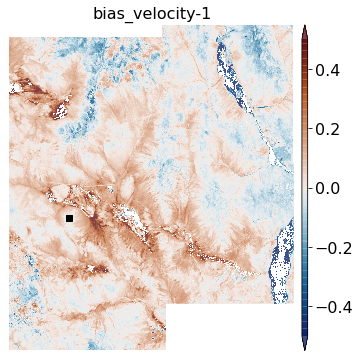

In [9]:
# map of bias velocity at con-1 level (Fig.7(a) in Zheng et al., TGRS, 2022)
view.main('Wratio.h5 bias_velocity-1 -c vik -v -0.5 0.5 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose'.split())

view.py Wratio.h5 wratio-2 -c gray -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose


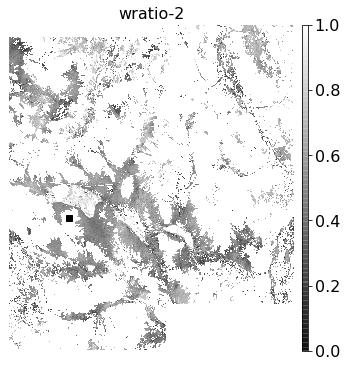

In [10]:
# map of Wratio-2, the second diagnoal component of W^r (w(2\delta_t)/w(delta_t) (Eq.[20] Zheng et al., TGRS, 2022)
view.main('Wratio.h5 wratio-2 -c gray -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose'.split())

In [11]:
# calculate bias velocity of bw-5 analysis from the approximate bias timeseries
!timeseries2velocity.py bias_timeseries_approx.h5 -o bias_velocity_approx.h5
# correct original time-series
!diff.py bw5/timeseries.h5 bias_timeseries_approx.h5 -o timeseries_cor_approx.h5
# calculate corrected velocity of bw-5 analysis
!timeseries2velocity.py timeseries_cor_approx.h5 -o velocity_cor_approx.h5

open timeseries file: bias_timeseries_approx.h5
--------------------------------------------------
dates from input file: 153
['20170203', '20170227', '20170510', '20170522', '20170603', '20170615', '20170627', '20170709', '20170721', '20170802', '20170814', '20170826', '20170907', '20170919', '20171013', '20171025', '20171106', '20171118', '20171130', '20171212', '20171224', '20180105', '20180117', '20180129', '20180210', '20180222', '20180306', '20180318', '20180330', '20180411', '20180423', '20180505', '20180517', '20180529', '20180610', '20180622', '20180704', '20180716', '20180728', '20180809', '20180821', '20180902', '20180914', '20180926', '20181008', '20181020', '20181101', '20181113', '20181125', '20181207', '20181219', '20181231', '20190112', '20190124', '20190205', '20190217', '20190301', '20190313', '20190325', '20190406', '20190430', '20190512', '20190524', '20190605', '20190617', '20190629', '20190711', '20190723', '20190804', '20190816', '20190822', '20190828', '20190903

skip pixels with zero/nan value in all acquisitions
number of pixels to invert: 1282734 out of 1428750 (89.8%)
estimating time functions via linalg.lstsq ...
estimating time function STD from time-series fitting residual ...
--------------------------------------------------
open  HDF5 file velocity_cor_approx.h5 in a mode
writing dataset /velocity                  block: [0, 1270, 0, 1125]
close HDF5 file velocity_cor_approx.h5.
--------------------------------------------------
open  HDF5 file velocity_cor_approx.h5 in a mode
writing dataset /velocityStd               block: [0, 1270, 0, 1125]
close HDF5 file velocity_cor_approx.h5.
time used: 00 mins 6.3 secs.


view.py bw5/velocity.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose


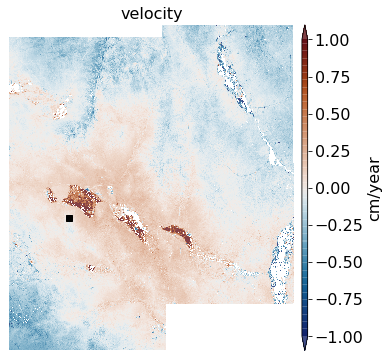

view.py bias_velocity_approx.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose


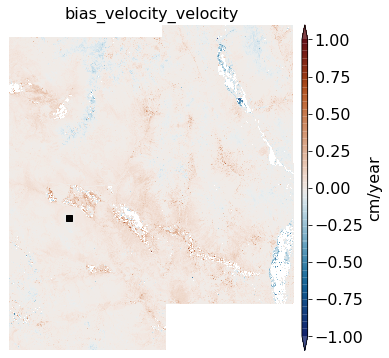

view.py velocity_cor_approx.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose


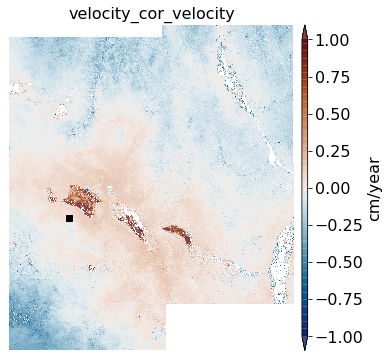

In [12]:
# map of original velocity in a bw-5 analysis
view.main('bw5/velocity.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose'.split())
# map of bias velocity in a bw-5 analysis
view.main('bias_velocity_approx.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose'.split())
# map of corrected velocity of a bw-5 analysis
view.main('velocity_cor_approx.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose'.split())

## closure_phase_bias.py -- bias_estimate (option 3)
Implementing the algorithm as presented in Zheng et al., TGRS, 2022<br>
Note that it is important to use modify_network.py to make the maximum connection level in ifgramStack.h5 consistent with the input bandwidth (--bw)

In [13]:
!modify_network.py inputs/ifgramStack.h5 --max-conn-num 5

open ifgramStack file: ifgramStack.h5
number of interferograms: 1608
--------------------------------------------------
Drop ifgrams with temporal baseline beyond 5 neighbors: (858)
--------------------------------------------------
number of interferograms to remove: 858
number of interferograms to keep  : 750
Calculated date12 to drop is the same as exsiting marked input file, skip updating file.


In [14]:
!closure_phase_bias.py -i inputs/ifgramStack.h5 --bw 5 --nl 20 -a bias_estimate -o . --noupdate -c local

open ifgramStack file: ifgramStack.h5
maximum memory size: 4.0E+00 GB
split 1270 lines into 7 patches for processing
    with each patch up to 190 lines
--------------------------------------------------
create HDF5 file: ./bias_timeseries.h5 with w mode
create dataset  : timeseries of <class 'numpy.float32'>   in size of (153, 1270, 1125)    with compression = None
create dataset  : date       of |S8                       in size of (153,)               with compression = None
close  HDF5 file: ./bias_timeseries.h5
save the original settings of ['OMP_NUM_THREADS', 'OPENBLAS_NUM_THREADS', 'MKL_NUM_THREADS', 'NUMEXPR_NUM_THREADS', 'VECLIB_MAXIMUM_THREADS']
set OMP_NUM_THREADS = 1
set OPENBLAS_NUM_THREADS = 1
set MKL_NUM_THREADS = 1
set NUMEXPR_NUM_THREADS = 1
set VECLIB_MAXIMUM_THREADS = 1
(0, 0, 1125, 190)

------- processing patch 1 out of 7 --------------
box width:  1125
box length: 190


------- start parallel processing using Dask -------
input Dask cluster type: local
initiate Da

[==================================================] 53580/53580 pixels 
FUTURE #2 complete. Time used: 756 seconds
[==================================================] 53580/53580 pixels 
FUTURE #3 complete. Time used: 757 seconds
[==================================================] 53580/53580 pixels 
FUTURE #4 complete. Time used: 757 seconds
close dask cluster
close dask client
------- finished parallel processing -------


--------------------------------------------------
open  HDF5 file ./bias_timeseries.h5 in a mode
writing dataset /timeseries                block: [0, 153, 760, 950, 0, 1125]
close HDF5 file ./bias_timeseries.h5.
(0, 950, 1125, 1140)

------- processing patch 6 out of 7 --------------
box width:  1125
box length: 190


------- start parallel processing using Dask -------
input Dask cluster type: local
initiate Dask cluster
split patch into 4 sub boxes in x direction for workers to process
scale Dask cluster to 4 workers
initiate Dask client
submit a job to the 

After this step, we now have a new HDF5 file "bias_timeseries.h5".

In [15]:
# calculate bias velocity of bw-5 analysis from the bias timeseries
!timeseries2velocity.py bias_timeseries.h5 -o bias_velocity.h5
# correct original time-series
!diff.py bw5/timeseries.h5 bias_timeseries.h5 -o timeseries_cor.h5
# calculate corrected velocity of bw-5 analysis
!timeseries2velocity.py timeseries_cor.h5 -o velocity_cor.h5

open timeseries file: bias_timeseries.h5
--------------------------------------------------
dates from input file: 153
['20170203', '20170227', '20170510', '20170522', '20170603', '20170615', '20170627', '20170709', '20170721', '20170802', '20170814', '20170826', '20170907', '20170919', '20171013', '20171025', '20171106', '20171118', '20171130', '20171212', '20171224', '20180105', '20180117', '20180129', '20180210', '20180222', '20180306', '20180318', '20180330', '20180411', '20180423', '20180505', '20180517', '20180529', '20180610', '20180622', '20180704', '20180716', '20180728', '20180809', '20180821', '20180902', '20180914', '20180926', '20181008', '20181020', '20181101', '20181113', '20181125', '20181207', '20181219', '20181231', '20190112', '20190124', '20190205', '20190217', '20190301', '20190313', '20190325', '20190406', '20190430', '20190512', '20190524', '20190605', '20190617', '20190629', '20190711', '20190723', '20190804', '20190816', '20190822', '20190828', '20190903', '201

number of pixels to invert: 1282734 out of 1428750 (89.8%)
estimating time functions via linalg.lstsq ...
estimating time function STD from time-series fitting residual ...
--------------------------------------------------
open  HDF5 file velocity_cor.h5 in a mode
writing dataset /velocity                  block: [0, 1270, 0, 1125]
close HDF5 file velocity_cor.h5.
--------------------------------------------------
open  HDF5 file velocity_cor.h5 in a mode
writing dataset /velocityStd               block: [0, 1270, 0, 1125]
close HDF5 file velocity_cor.h5.
time used: 00 mins 5.8 secs.


view.py bw5/velocity.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose


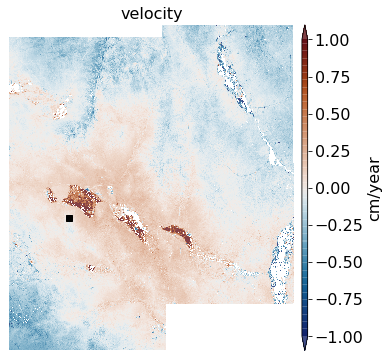

view.py bias_velocity.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose


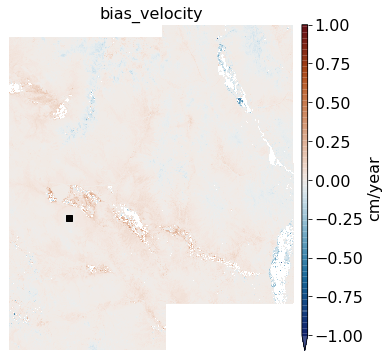

view.py velocity_cor.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose


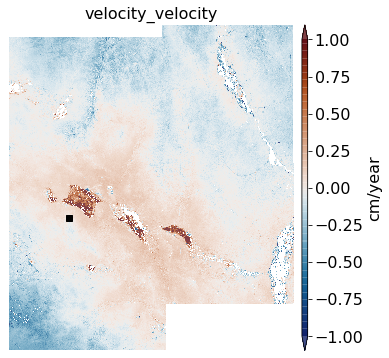

In [16]:
# map of original velocity in a bw-5 analysis
view.main('bw5/velocity.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose'.split())
# map of bias velocity in a bw-5 analysis
view.main('bias_velocity.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose'.split())
# map of corrected velocity of a bw-5 analysis
view.main('velocity_cor.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose'.split())

## Concluding remarks

- The folder "closure Phase" only needs to be calculated once. 
- We recommend trying option 2 before option 3. In our case, you can see that these two solutions are very close. What's more, option 2 also generates Wratios.h5 which allow you to exam whether your choice of $n_l$ is reasonable (by seeing whether the diagnoal components of $W^r$ (wratio-n) fades quickly).